# Ships added mass effect on a flexible mooring dolphin in a berthing manoeuvre

In [1]:
import sympy as sym
#from sympy import Function, Symbol
import sage

import scipy.special as sci_spc
import scipy.integrate as sci_int
import numpy as np
import math as mat
import cmath as cmat
import matplotlib.pyplot as plt
import matplotlib.patches as patch
import csv
from timeit import default_timer as timer

# NUMBA
from numba import jit

# MatPlotLib set LaTeX font
plt.rcParams['text.usetex'] = True

In [2]:
def lewis_coeff(bts):
    
    B = bts[0]
    T = bts[1]
    S = B*T*bts[2]

    #print('B={:.2f}, T={:.2f}, S={:.4f}'.format(B,T,S))
    
    si = S/(B*T)
    H = B/(2*T)
    
    c1 = (3+4*si/mat.pi) + (1-4*si/mat.pi)*((H-1)/(H+1))**2
    a3 = (-c1 + 3 + mat.sqrt(9-2*c1))/c1
    a1 = (1 + a3)*(H-1)/(H+1)
    a = B/2 * (1 + a1 + a3)
    
    return correct_draft([a, a1, a3],T)

def correct_draft(cf,T):
    
    cf_n = cf
    [x,y] = lewis_point(cf,0)
    ts = T/y
    
    cf_n[0] = cf_n[0]*ts
    
    return cf_n

def lewis_map(cf,z):
    
    a = cf[0]
    a1 = cf[1]
    a3 = cf[2]
    
    w = a*(z + a1/z + a3/z**3)
    return w

def lewis_point(cf,th):
    
    a = cf[0]
    a1 = cf[1]
    a3 = cf[2]
    
    x = a*( (1+a1)*np.sin(th) - a3*np.sin(3*th))
    y = a*( (1-a1)*np.cos(th) + a3*np.cos(3*th))
    
    return [x,y]

def water_height(H,B,T,fh):
# H  - water height in basin
# B  - ships breadth 
# T  - ships draft
# fh - cross section height

    ft = T*fh
    ukc = (H - ft)/T # scaled by T
    
    return 1+ukc  

def displacement(bts,sp,k):

    L = sp[1]
    B = sp[2]
    T = sp[3][k]
    
    # Scaling for real B and T
    rbt = (B/T)/2
    
    #print(' -> displacement(): L={}, B={}, T={}, rtb={:.3f}'.format(L,B,T,rbt))
    #print(' -> bts(): {}'.format(bts))
    
    N = len(bts)
    D = 0.0
    for i in range(N):
        Si = bts[i][0]*rbt*T * bts[i][1]*T * bts[i][2]# section surface
        Li = bts[i][3] * L    # section volume
        D += Si * Li
        
    Cb = D/(L*B*T)
        
    return [D,Cb]

In [3]:
def calculate_ship_added_mass(bts,sp,Hw,intf):
    
    L = sp[0]
    B = sp[1]
    T = sp[2]
    fh = bts[1] # cross section (frame) height
    
    # Scaling factor for real ship  B and T
    # Lewis ship has B/T=2
    rbt = (B/T)/2
    bts_n = [bts[0]*rbt, bts[1], bts[2]]  
    
    # set dimensionless water depth
    Hc = water_height(Hw,B,T,fh)
    # obtain foem Lewis coefficients
    cf = lewis_coeff(bts_n)
    
    # Solve for unit speed U=1
    intf_p = intf.subs({rh:1,h:Hc,c0:cf[0],c1:cf[1],c3:cf[2]})
    ffx = (intf_p).subs(th,x)
    fnc = sym.lambdify(x, ffx, 'numpy')
    
    # added mass coefficient for frame
    S = bts_n[0] * bts_n[1] * bts_n[2]
    vI = 2*sci_int.quad(fnc, 0, mat.pi/2)[0]
    
    #print('S={:.3f}, I={:.3f}'.format(S,vI))
    
    # cross secion added mass coefficient
    c22 = vI/S 
    
    # Return nondimensional added mass coefficient and
    # nondimensional UKC (scaled by draft)
    return [c22, (Hc-1)]

In [4]:
# Start calculation added mass coefficients
def ship_added_mass(bts,sp,Hw,int_f,nt_lim,dbg):
    
    L = sp[1]
    B = sp[2]
    T = sp[3]
    
    # Set number of drafts
    if nt_lim != None:
        Nt = nt_lim
    else:
        Nt = len(T) # drafts size
    
    Nbts = len(bts)
    results = []
    am = []
    
    print('Start analysis for ship type: {:s}'.format(sp[0]))
      
    for i in range(Nt):
        for j in range(Nbts):
            
            # Cross section added mass coefficient for sway motion - dimensionless
            [c22, ukc] = calculate_ship_added_mass(bts[j],[L,B,T[i]],Hw,int_f)
            
            # Scaling for real B and T   
            rbt = (B/T[i])/2
            
            # Cross section area = B*L* 2*si
            Sj = (bts[j][0]*rbt)*T[i] * bts[j][1]*T[i] * bts[j][2]
            
            # Cross section lenght = L*dX_i
            Lj = bts[j][3] * L
            
            # Cross section added mass = c22 * V
            am22 = c22 * Lj * Sj      

            am.append([c22, am22])
            
            if dbg == 1:
                print('  ->  Done frame={}/{} for UKC({}/{})={:.1f}%, c22={:.3f}, m22={:.3f}'.format(j+1,Nbts,i+1,Nt,ukc*100,c22,am22))

        am = np.array(am, dtype=float) 
        results.append([T[i],am])
        amS = np.sum(am)
        am = []
        
        [disp, Cb] = displacement(bts,sp,i)
        print('ship: T={}/{}({:.2f}), D={:.3f}, a22={:.3f}, a22/D={:.3f}'.format(i+1,Nt,T[i],disp,amS,amS/disp))
        
    return results

In [5]:
def postprocess_ship_adde_mass(result,sp,bts,Hw):
    
    print('Start post-process for ship type: {:s}'.format(sp[0]))
    file_name = 'results_{:s}.csv'.format(sp[0])
    Nr = len(result)
    
    L = sp[1]
    B = sp[2]
    
    with open(file_name, 'w', newline='') as csvfile:
        fieldnames = ['L','B','T','Cb','Disp','UKC','am']
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)

        writer.writeheader()
    
    
        for i in range(Nr):
            T = sp[3][i]
            am = result[i][1]

            [disp, Cb] = displacement(bts,sp,i)
            am_sum = np.sum(am[:,1]) # mass_coeff
            ukc = Hw - T
            
            writer.writerow({
                'L':'{:.2f}'.format(L),
                'B':'{:.2f}'.format(B),
                'T':'{:.2f}'.format(T),
                'Cb':'{:.5f}'.format(Cb),
                'Disp':'{:.2f}'.format(disp),
                'UKC':'{:.2f}'.format(ukc),
                'am':'{:.2f}'.format(am_sum)
                            })
            
            print(' -> UKC/T = {:.2f}%'.format(ukc/T*100))
            print('    Disp = {:.2f}m3, Cb={:.3f}, am = {:.2f}m3'.format(disp,Cb,am_sum))
            print('    am/D = {:.2f}%'.format(am_sum/disp*100))

In [6]:
sym.init_printing()

In [7]:
x,y,h = sym.symbols('x y h', real=True)
rh,th = sym.symbols('rho theta', real=True)
z = sym.symbols('z', complex=True)
c0,c1,c3 = sym.symbols('c_0 c_1 c_3', real=True)

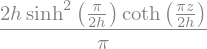

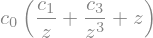

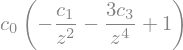

In [8]:
cp = (2*h)/sym.pi * sym.sinh(sym.pi/(2*h))**2 * sym.coth(sym.pi*z/(2*h))
#cp = 1/z
#
w = c0*(z+c1/z+c3/z**3)
g = sym.I*sym.exp(-sym.I*th)
#
dwdz = w.diff(z)
#
display(cp)
display(w)
display(g)
display(dwdz)

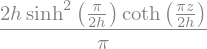

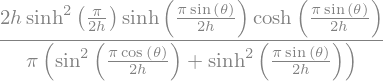

In [9]:
# Expand potential in series for checking process
#f = cp.series(z,0,3).removeO()

# Else put it as the original function
f = cp

display(f)

# Calculate the real part phi
phi = sym.re(f.subs(z,sym.I*sym.exp(-sym.I*th))).simplify()
display(phi)

Text(0.5, 1.0, 'Velocity potential $\\phi$')

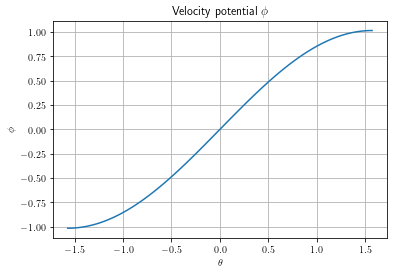

In [10]:
# Plot real part of the complex velocity potential
#
pp_x = []
th_v = np.linspace(-mat.pi/2,mat.pi/2,100)
fig, ax = plt.subplots()
for tt in th_v:
    pp_x.append(phi.subs(h,10).subs(th,tt))
pp_x = np.array(pp_x, dtype=float)

ax.plot(th_v,pp_x)
ax.set_xlabel(r'$\theta$')
ax.set_ylabel(r'$\phi$')
ax.grid(True)
plt.title(r'Velocity potential $\phi$')

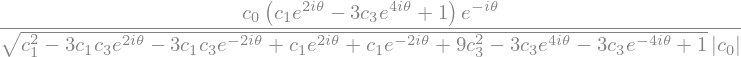

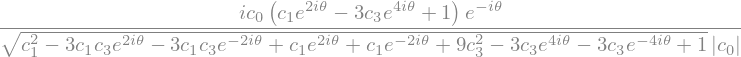

In [11]:
# Tangent and Normal vector in W space desctibed in Z
tv = (w.diff(z).subs(z,g)*g.diff(th))
tv = tv/sym.Abs(tv)
nv = sym.I*tv

display(tv)
display(nv)

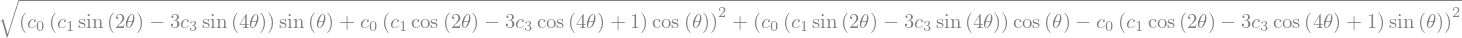

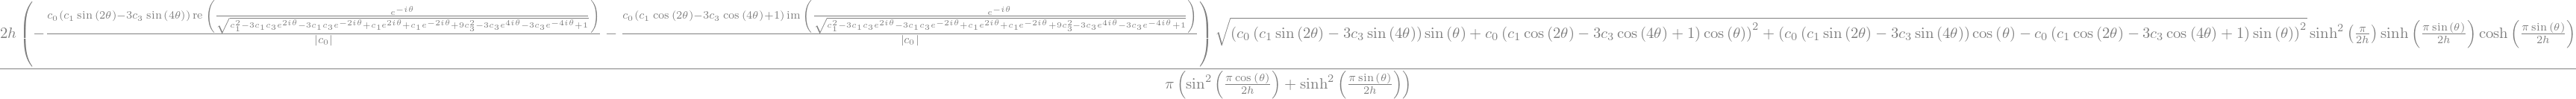

In [12]:
nx = sym.re(nv)
ny = sym.im(nv)

jac = dwdz.subs(z,g) * g.diff(th)
abs_jac = sym.sqrt(sym.re(jac)**2 + sym.im(jac)**2)
int_f = phi * nx * abs_jac 

display(jac)
display(abs_jac)
display(int_f)

Text(0.5, 1.0, 'Integral function')

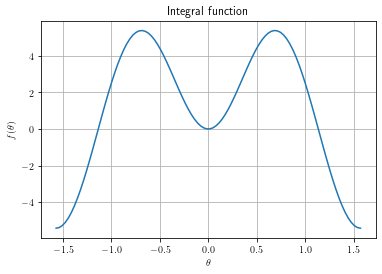

In [13]:
# Plot of added mass coefficient function for a specific cross section
#
Hc = 1.5
cf = lewis_coeff([2.0,1.0,0.99,0.60])
int_f_p = int_f.subs({rh:1,h:Hc,c0:cf[0],c1:cf[1],c3:cf[0]})
ffx = (int_f_p).subs(th,x)
fnc = sym.lambdify(x, ffx, 'numpy')

fip = []
th_v = np.linspace(-mat.pi/2,mat.pi/2,100)
fig, ax = plt.subplots()
for tt in th_v:
    fip.append(fnc(tt))
fip = np.array(fip, dtype=float)

ax.plot(th_v,fip)
ax.set_xlabel(r'$\theta$')
ax.set_ylabel(r'$f(\theta)$')
ax.grid(True)
plt.title(r'Integral function')

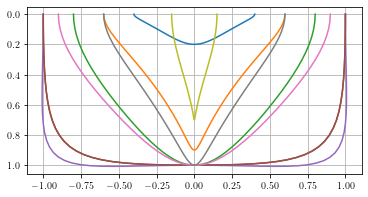

In [14]:
# Unified tanker shape [B,T,si,li]
# B  - cross section breadth
# T  - cross section draft
# si - cross section unit surface
# li - cross section length
#
# Article: Values are in Table 1
#

BTsi = [
    [0.8,0.2,0.6,0.05],
    [1.2,0.9,0.5,0.05],
    [1.6,1.0,0.68,0.05],
    [2.0,1.0,0.93,0.05],
    [2.0,1.0,0.99,0.60],
    [2.0,1.0,0.93,0.05],
    [1.8,1.0,0.68,0.05],
    [1.2,1.0,0.56,0.05],
    [0.3,0.7,0.56,0.05]
]
    
Nbts = len(BTsi)

thv = np.linspace(-mat.pi/2,mat.pi/2,50)
fig, ax = plt.subplots()
for i in range(Nbts):
    cf = lewis_coeff(BTsi[i])
    [xp, yp] = lewis_point(cf,thv)
    ax.plot(xp,yp)

ax.set_aspect(aspect=1)
ax.grid(True)
fig.gca().invert_yaxis()

In [15]:
# Ship particulars [type,[Li,Bi,Ti],...]
#
# type - tanker type ID
# L - length
# B - breadth
# Ti - drought set

ntd = 20 # number of draft divisions

Ti_MR = np.linspace(10.5,8.5,ntd)
sp_MR = ['MR',185,29.1,Ti_MR]

Ti_LR1 = np.linspace(12.5,10.5,ntd)
sp_LR1 = ['LR1',220,36.3,Ti_LR1]

Ti_LR2 = np.linspace(14.2,12.2,ntd)
sp_LR2 = ['LR2',238,41.3,Ti_LR2]

In [16]:
print('MR:')
for i in range(ntd):
    [disp,Cb] = displacement(BTsi,sp_MR,i)
    print(' -> Disp@(T={:.2f}m): {:.2f}m3, Cb={:.5f}'.format(sp_MR[3][i],disp,Cb))

print('LR-01:')
for i in range(ntd):
    [disp,Cb] = displacement(BTsi,sp_LR1,i)
    print(' -> Disp@(T={:.2f}m): {:.2f}m3, Cb={:.5f}'.format(sp_LR1[3][i],disp,Cb))

print('LR-02:')
for i in range(ntd):
    [disp,Cb] = displacement(BTsi,sp_LR2,i)
    print(' -> Disp@(T={:.2f}m): {:.2f}m3, Cb={:.5f}'.format(sp_LR2[3][i],disp,Cb))

MR:
 -> Disp@(T=10.50m): 44115.74m3, Cb=0.78044
 -> Disp@(T=10.39m): 43673.47m3, Cb=0.78044
 -> Disp@(T=10.29m): 43231.21m3, Cb=0.78044
 -> Disp@(T=10.18m): 42788.95m3, Cb=0.78044
 -> Disp@(T=10.08m): 42346.68m3, Cb=0.78044
 -> Disp@(T=9.97m): 41904.42m3, Cb=0.78044
 -> Disp@(T=9.87m): 41462.16m3, Cb=0.78044
 -> Disp@(T=9.76m): 41019.90m3, Cb=0.78044
 -> Disp@(T=9.66m): 40577.63m3, Cb=0.78044
 -> Disp@(T=9.55m): 40135.37m3, Cb=0.78044
 -> Disp@(T=9.45m): 39693.11m3, Cb=0.78044
 -> Disp@(T=9.34m): 39250.84m3, Cb=0.78044
 -> Disp@(T=9.24m): 38808.58m3, Cb=0.78044
 -> Disp@(T=9.13m): 38366.32m3, Cb=0.78044
 -> Disp@(T=9.03m): 37924.05m3, Cb=0.78044
 -> Disp@(T=8.92m): 37481.79m3, Cb=0.78044
 -> Disp@(T=8.82m): 37039.53m3, Cb=0.78044
 -> Disp@(T=8.71m): 36597.27m3, Cb=0.78044
 -> Disp@(T=8.61m): 36155.00m3, Cb=0.78044
 -> Disp@(T=8.50m): 35712.74m3, Cb=0.78044
LR-01:
 -> Disp@(T=12.50m): 77907.42m3, Cb=0.78044
 -> Disp@(T=12.39m): 77251.36m3, Cb=0.78044
 -> Disp@(T=12.29m): 76595.30m3, Cb=

In [17]:
# *************************************************
# *** Start calculation added mass coefficients ***
# *************************************************
#

# Set basin water depth
Hw = 14.5   # m

# Drafts computation limit
nt_l = None
dbg = 0

# MR - Middle Range oil tanker, 25.000-55.000 DWT
tstart = timer()
result_MR = ship_added_mass(BTsi,sp_MR,Hw,int_f,nt_l,dbg)
tend = timer()
print('e-time={:.2f}s'.format(tend-tstart))

# LR1 - Long Range 01 oil tanker, 55.000-80.000 DWT
tstart = timer()
result_LR1 = ship_added_mass(BTsi,sp_LR1,Hw,int_f,nt_l,dbg)
tend = timer()
print('e-time={:.2f}s'.format(tend-tstart))

# LR2 - Long Range 02 oil tanker, 80.000-160.000 DWT
tstart = timer()
result_LR2 = ship_added_mass(BTsi,sp_LR2,Hw,int_f,nt_l,dbg)
tend = timer()
print('e-time={:.2f}s'.format(tend-tstart))

Start analysis for ship type: MR
ship: T=1/20(10.50), D=44115.737, a22=70407.920, a22/D=1.596
ship: T=2/20(10.39), D=43673.474, a22=68104.445, a22/D=1.559
ship: T=3/20(10.29), D=43231.211, a22=65868.573, a22/D=1.524
ship: T=4/20(10.18), D=42788.948, a22=63698.392, a22/D=1.489
ship: T=5/20(10.08), D=42346.685, a22=61592.042, a22/D=1.454
ship: T=6/20(9.97), D=41904.422, a22=59547.715, a22/D=1.421
ship: T=7/20(9.87), D=41462.159, a22=57563.654, a22/D=1.388
ship: T=8/20(9.76), D=41019.896, a22=55638.151, a22/D=1.356
ship: T=9/20(9.66), D=40577.633, a22=53769.547, a22/D=1.325
ship: T=10/20(9.55), D=40135.370, a22=51956.226, a22/D=1.295
ship: T=11/20(9.45), D=39693.107, a22=50196.622, a22/D=1.265
ship: T=12/20(9.34), D=39250.843, a22=48489.209, a22/D=1.235
ship: T=13/20(9.24), D=38808.580, a22=46832.506, a22/D=1.207
ship: T=14/20(9.13), D=38366.317, a22=45225.072, a22/D=1.179
ship: T=15/20(9.03), D=37924.054, a22=43665.509, a22/D=1.151
ship: T=16/20(8.92), D=37481.791, a22=42152.457, a22/D=1

In [18]:
# Calculation specific ship added mass
# including measured approacing velocitiy
#

# Middle Range tanker
postprocess_ship_adde_mass(result_MR,sp_MR,BTsi,Hw)
print('')

# Long Range - 01 tanker
postprocess_ship_adde_mass(result_LR1,sp_LR1,BTsi,Hw)
print('')

# Long Range - 02 tanker
postprocess_ship_adde_mass(result_LR2,sp_LR2,BTsi,Hw)

Start post-process for ship type: MR
 -> UKC/T = 38.10%
    Disp = 44115.74m3, Cb=0.780, am = 70379.43m3
    am/D = 159.53%
 -> UKC/T = 39.49%
    Disp = 43673.47m3, Cb=0.780, am = 68076.55m3
    am/D = 155.88%
 -> UKC/T = 40.92%
    Disp = 43231.21m3, Cb=0.780, am = 65841.26m3
    am/D = 152.30%
 -> UKC/T = 42.38%
    Disp = 42788.95m3, Cb=0.780, am = 63671.65m3
    am/D = 148.80%
 -> UKC/T = 43.86%
    Disp = 42346.68m3, Cb=0.780, am = 61565.86m3
    am/D = 145.39%
 -> UKC/T = 45.38%
    Disp = 41904.42m3, Cb=0.780, am = 59522.09m3
    am/D = 142.04%
 -> UKC/T = 46.93%
    Disp = 41462.16m3, Cb=0.780, am = 57538.57m3
    am/D = 138.77%
 -> UKC/T = 48.52%
    Disp = 41019.90m3, Cb=0.780, am = 55613.59m3
    am/D = 135.58%
 -> UKC/T = 50.14%
    Disp = 40577.63m3, Cb=0.780, am = 53745.51m3
    am/D = 132.45%
 -> UKC/T = 51.79%
    Disp = 40135.37m3, Cb=0.780, am = 51932.70m3
    am/D = 129.39%
 -> UKC/T = 53.48%
    Disp = 39693.11m3, Cb=0.780, am = 50173.60m3
    am/D = 126.40%
 -> UK